In [1]:
import numpy as np
import brainpy as bp
import brainpy.math as bm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"  # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')
import torch

from sbi.inference import (
    likelihood_estimator_based_potential,
    SNLE,
    prepare_for_sbi,
    simulate_for_sbi,
    VIPosterior,
)

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from HH_helper_bp import *

# For SNPE：posterior_nn(). SNLE: likelihood_nn(). For SNRE: classifier_nn(), 
# sbi
from sbi.inference import SNPE, SNRE, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn, classifier_nn
from sbi import utils as utils
from sbi import analysis as analysis
from scipy.stats import kurtosis as kurt
from sbi.utils.user_input_checks import process_pytorch_prior, process_simulator

/home/spirit/anaconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
total_time = 1.0/2 * 1000.  # 总时长 (s)
t_on = 0.1156/2 * 1000.  # 刺激启始时刻 (s)
t_off = 0.5156/2 * 1000.  # 刺激结束时刻 (s)
I_current_amplitude   = 30.0
dt    = 0.1
syn_current, duration = bp.inputs.section_input(values=[0, I_current_amplitude, 0.],
                                             durations=[t_on, t_off - t_on, total_time - t_off],
                                             return_length=True,
                                             dt=0.1)

In [3]:
def run_HH_model(params):
    params = bm.asarray(params)
    t = np.arange(0, len(syn_current), 1) * dt
    neuron = Body_Wall_muscle(size= params.shape[0])
    neuron.gCa = params[:,0]
    neuron.gK  = params[:,1]
    neuron.gL  = params[:,2]
    neuron.C   = params[:,3]
    neuron.g_slo2  = params[:,4]
    neuron.V_th  = params[:,5]
    runner = bp.DSRunner(
        neuron, 
        monitors=['spike', 'V'], 
        inputs=('input', syn_current,'iter'),  # constant external inputs of 22 mA to all neurons
        dt=dt,
        progress_bar=False
    )
    runner.run(duration)  # the running time is 200 ms
    return dict(data = runner.mon.V.T, spikes = runner.mon.spike.T, time = t, dt = dt)

In [4]:
time_to_first_spike = lambda x: np.where(x)[0][0] if np.any(x) else 0
def compute_mean_isi(neuron_spikes):
    spike_times = np.where(neuron_spikes)[0]
    if len(spike_times) > 1:
        intervals = np.diff(spike_times)
        return np.mean(intervals)
    else:
        return 0.

def calculate_summary_statistics(x):
    v =  np.array(x["data"])
    t = x["time"]
    dt = x["dt"]
    # v[v < -10] = -10
    # diff_v = np.diff(v, axis=1)
    # v[:, :-1][diff_v < 0] = -10

    # Resting potential and std
    rest_pot = np.mean(v[:, t < t_on], axis=1)
    rest_pot_std = np.std(v[:, int(0.8 * t_on / dt):int(t_on / dt)], axis=1)
    
    # Mean and standard deviation during stimulation
    v_stim = v[:, (t > t_on) & (t < t_off)]
    mean_v_stim = np.mean(v_stim, axis=1)
    std_v_stim  = np.std(v_stim, axis=1)
    kurt_v_stim = kurt(v_stim, axis=1,fisher=False)
    max_v_stim  = np.max(v_stim, axis=1) / 10.0

    # spike calculation
    spike_counts = x['spikes'].sum(axis=1)
    mean_isi_values = np.apply_along_axis(compute_mean_isi, axis=1, arr=x['spikes']) * dt
    first_spike_times = np.apply_along_axis(time_to_first_spike, axis=1, arr=x['spikes']) * dt

    sum_stats_vec = np.column_stack((
        spike_counts,
        mean_isi_values/20.,
        first_spike_times/20.,
        rest_pot/10.,
        # rest_pot_std,
        # mean_v_stim,
        # std_v_stim,
        # kurt_v_stim,
        # max_v_stim
    ))
    return sum_stats_vec

def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    Summarizes the output of the simulation and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats.to(torch.float32)

In [5]:
prior_min = [10. , 10.5, 1e-4, 10., 1.5, 7.0]
prior_max = [25.0, 45.0,  0.5,  30.,  2.5, 13.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                        high=torch.as_tensor(prior_max))

In [6]:
# Simulate samples from the prior distribution
num_rounds = 3
posteriors = []
proposal = prior

true_params = np.array([[19.8, 37., 0.1, 22., 2.1, 10.]])
true_data = run_HH_model(true_params)
xo = calculate_summary_statistics(true_data)
xo = torch.tensor(xo, dtype=torch.float32)
# x_aike =[[5.       ,  103.625   ,    70.2    ,    -29.00938034  , 0.21364328,
#   -11.58708191 , 17.44003296  , 3.21818399  , 3.58649588]]
# xo = torch.tensor(x_aike, dtype=torch.float32)

inference = SNLE(prior)
for _ in range(num_rounds):
    theta = proposal.sample((1600,))
    stats = simulation_wrapper(theta)
    print('done.')
    likelihood_estimator = inference.append_simulations(
        theta, stats,
    ).train()
    print('Training inference network... ')
    potential_fn, theta_transform = likelihood_estimator_based_potential(
        likelihood_estimator, prior, xo
    )
    posterior = VIPosterior(
        potential_fn, prior, "maf", theta_transform, vi_method="fKL",
    ).train()
    posteriors.append(posterior)
    proposal = posterior
    

done.
 Training neural network. Epochs trained: 24

KeyboardInterrupt: 

In [ ]:
# true parameters for real ground truth data
true_params = np.array([[19.8, 37., 0.1, 22., 2.1, 10.]])
true_data = run_HH_model(true_params)
t = true_data['time']
I_inj = syn_current
v = true_data['data']
xo = calculate_summary_statistics(true_data)
print("The true summary statistics are:  ", xo)

The true summary statistics are:   [[ 4.          2.41833333  4.6        -3.09582829]]


In [ ]:
# lower = true_params[0] - 0.1 * np.array(true_params[0])
# upper = true_params[0] + 0.1 * np.array(true_params[0])
# lower[-1] = 0.
# upper[-1] = 20.
# draw_list =[[l, u] for l, u in zip(lower, upper)]
draw_list = [[0.5, 80.], [0.1, 55.], [1e-4, 1.], [10., 50.], [1e-1, 4.0], [0., 20.]]

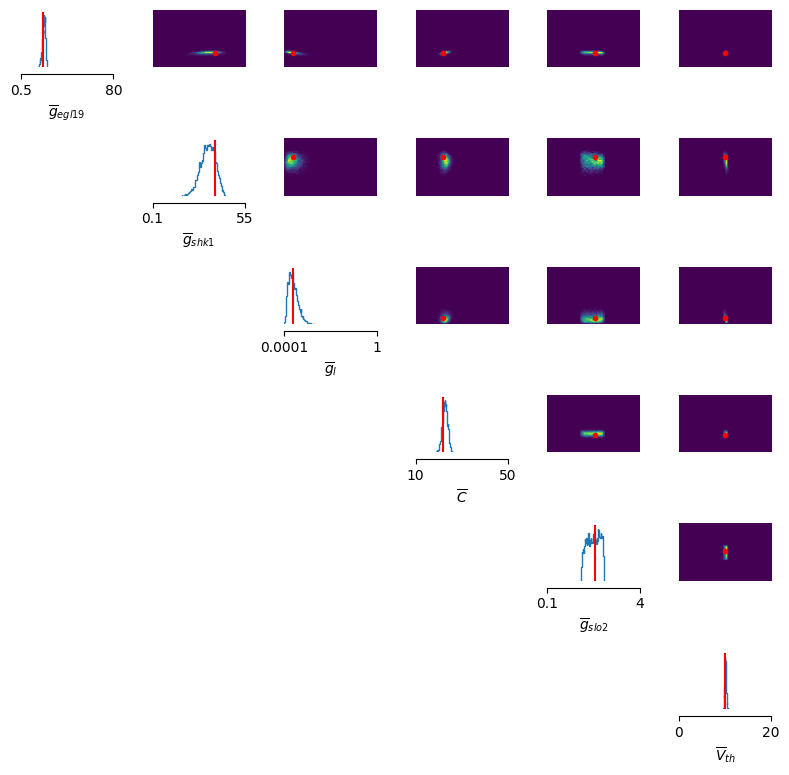

In [9]:
# Plot estimated posterior distribution

samples = posterior.sample((5000,), x=xo, show_progress_bars=False)
labels_params = [r'$\overline{g}_{egl19}$', r'$\overline{g}_{shk1}$', r'$\overline{g}_{l}$', r'$\overline{C}$',r'$\overline{g}_{slo2}$',r'$\overline{V}_{th}$']
analysis.pairplot(samples,
                        # limits=[[0.5, 80], [1e-1, 15.0], [1e-4,10], [0.01, 5.0],[1e-4, 1.0],[0.0, 20.0]],
                        # ticks=[[0.5, 80], [1e-4, 15.0],  [1e-4,10], [0.01, 5.0],[1e-4,1.0],[0.0, 20.0]],
                        limits=draw_list,
                        ticks= draw_list,
                        figsize=(8, 8),
                        points=true_params, labels=labels_params,
                        points_offdiag={'markersize': 6},
                        points_colors=['r'])
plt.tight_layout()
plt.savefig('Body_Wall_Muscle_posterior2.png', dpi=300)

In [12]:
posterior_sample

array([[19.777252  , 34.692375  ,  0.16428109, 23.413435  ,  2.3384812 ,
         9.890497  ]], dtype=float32)

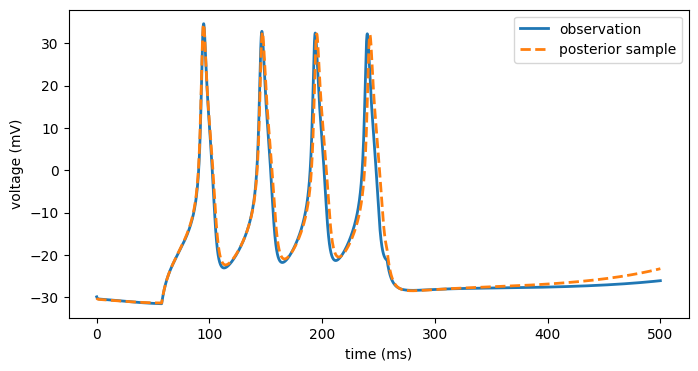

In [10]:
# Draw a single sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=xo,
                                    show_progress_bars=False).numpy()
x = run_HH_model(posterior_sample)

# plot observation and sample
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, v[0,:], lw=2, label='observation')
ax.plot(t, x["data"][0,:], '--', lw=2, label='posterior sample')
ax.legend()
ax.set(xlabel='time (ms)', ylabel='voltage (mV)')
plt.savefig('HH_sbi_posterior_sample.png', dpi=300)
plt.show()

In [11]:
np.savez('Body_Wall_Muscle_posterior.npz', samples=samples, true_params=true_params, true_data=true_data, xo=xo, posterior_sample=posterior_sample,)